# **Intro M2**
<!-- In this notebook I set up semi-supervised VAE to predict cell type proportions from bulk data.
This is the original model structure (M1)
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)". -->

This is the updated model structure (M2) -- which we use for our main analyses.
This model directly inserts the cell type proportions as a section of the latent code when available and simultaneously trains a cell-type proportion predictor. When the cell-type proportions are not available, the proportion predictor is used to generate the relevant section in the latent code.

To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: cell-type proportion, sample-id, and everything else (slack).
To enforce this disentanglement, there are classification losses on the cell-type and smaple_id embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.
The model is depicted below.



The experimental set-up is as follows:
All data is from pbmc6k dataset.
Cells are sampled to generate 10 pesudobulks.
There are perturbed samples --> this means that for some samples we have mono14 cells instead of mono16 cells. 
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the labeled data (meaning each sample has a ground truth) and 8 samples with unlabeled data (ground truth proportions are not used in training.)




This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


# M2
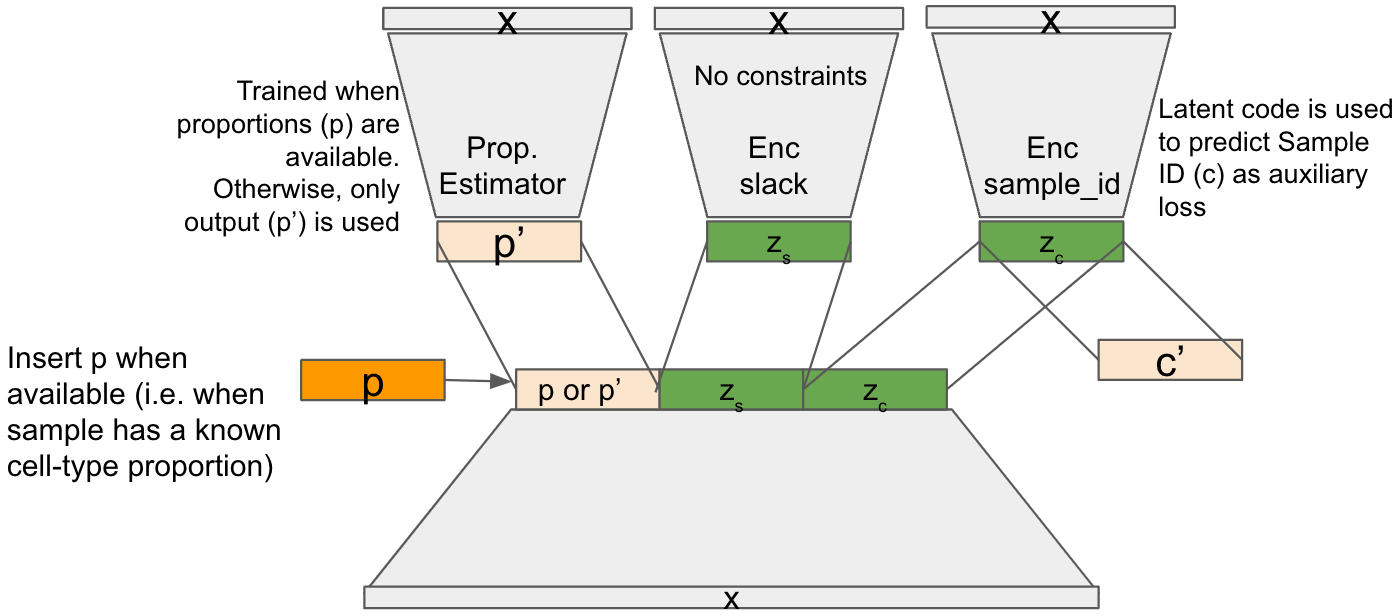

# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from matplotlib_venn import venn2

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_pbmc_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/diva_pbmc/"
num_genes = 5000

exp_id = "pbmc6k-mono"

# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

#if args.exp_id != "pbmc68k":
#    sys.exit("Error, exp_id not currently supported")
        
# number expected cell types
n_cell_types = 7

# number of patients/domains/samples expected
idx_range = range(0, 10)
#idx_range_unlab = range(0, 10)
n_tot_samples = 10

# number of drugs (one-hot encoded)
n_drugs = 2

# experiment id
lab_file_name = exp_id
#unlab_file_name = args.unlab_exp_id

# number of pseudobulks PER patient
n_train = 1000



### create the domains label 
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 7),
                            np.full(n_train, 8), np.full(n_train, 9)], axis=0)
label_full = to_categorical(Label_full)

### create the drugs label 
Drug_full = np.concatenate([np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 1), np.full(n_train, 1),
                            np.full(n_train, 0), np.full(n_train, 0)], axis=0)
drug_full = to_categorical(Drug_full)

# indexes for the training
# 1-9 is labeled training
# 11-19 is unlabeled
# 10 is held out to test
# 0 is held out
#idx_train = np.where(np.logical_and(Label_full>0, Label_full!=3))[0]
#idx_unlab = np.where(Label_full == 3)[0]
#idx_0 = np.where(Label_full==0)[0]

idx_train = np.where(np.logical_and(Label_full > 0, Label_full < 5))[0]
idx_unlab = np.where(Label_full > 5)[0]
idx_drug = np.where(Drug_full > 0)[0]
idx_5 = np.where(Label_full == 5)[0]
idx_0 = np.where(Label_full==0)[0]

idx_train = np.where(np.logical_and(Label_full > -1, Label_full < 2))[0]
idx_unlab = np.where(Label_full >= 2)[0]
idx_drug = np.where(Drug_full > 0)[0]
idx_5 = np.where(Label_full == 5)[0]
idx_0 = np.where(Label_full==0)[0]



# **Load / Pre-process data**
Import pre-processed pseudobulks

In [223]:

##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_train, Y_train, gene_df = sc_preprocess.read_all_diva_files(aug_data_path, idx_range, lab_file_name)
X_train.columns = gene_df

# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "intersection_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_pbmc/CIBERSORTx_Job12_pbmc6k_0_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job12_pbmc6k_0_cybersort_sig_inferred_refsample.bm.K999.txt"
cibersort_df = pd.read_csv(cibersort_file_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

common_genes = np.union1d(common_genes, cibersort_genes)

X_train = X_train[common_genes]
X_train.head()

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_full = X_train.to_numpy()
Y_full = Y_train.to_numpy()

## get the top variable genes
X_colmean = X_full.mean(axis=0)
X_colvar = X_full.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
gene_df = gene_df.iloc[idx_top]



In [5]:
np.sort(X_colmean)

array([2.6015, 2.6331, 2.9744, ..., 1872502.2416, 2487755.1301,
       3309073.5586], dtype=object)

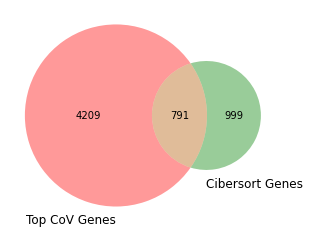

In [6]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [225]:
union_genes = np.union1d(gene_df, cibersort_genes)

In [226]:
X_full = X_train.loc[:,union_genes]
X_full = X_full.to_numpy()

## normalize within sample
X_full = scale(X_full, axis=1)
            
print(X_full.shape)

print(np.where(X_colmean == 0)[0].tolist())



# for unknown proportions; i.e. 3 
X_unkp = X_full[idx_unlab,]
label_unkp = label_full[idx_unlab,]
drug_unkp = drug_full[idx_unlab,]
y_unkp = Y_full[idx_unlab,]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
drug_kp = drug_full[idx_train,]
y_kp = Y_full[idx_train,]


# test
X_0 = X_full[idx_0,]
label_0 = label_full[idx_0,]
drug_0 = drug_full[idx_0,]
y_0 = Y_full[idx_0,]

(10000, 5999)
[]


In [227]:
X_train

gene_ids ENSG00000000419 ENSG00000000457 ENSG00000000460 ENSG00000000938  \
0                   2289             420             360            1158   
0                   1872             330             749             675   
0                   2720             361             175             149   
0                   1964             199             413            4151   
0                   3166             429             132             644   
..                   ...             ...             ...             ...   
0                  11700              96              39            7476   
0                  12656             127               6             853   
0                   9786             159              13            3379   
0                   9681              92              32            5023   
0                  13462             194              27            7301   

gene_ids ENSG00000000971 ENSG00000001036 ENSG00000001084 ENSG00000001167  \
0                    502             797             341            1271   
0                    282             260              39             887   
0                   1512             586             385            1404   
0                     72            1445             189            1243   
0                   1078             605             420             901   
..                   ...             ...             ...             ...   
0                    181             738              64             737   
0                     18             246              62             906   
0                     49             234              77             762   
0                    263             428             101             912   
0                    305             453              75            1449   

gene_ids ENSG00000001460 ENSG00000001461  ... ENSG00000273338 ENSG00000273344  \
0                    151            3617  ...            1159            1224   
0                    226            2803  ...             828            1935   
0                    273            3351  ...             601            1066   
0                     39            2889  ...            1079             470   
0                    234            2858  ...             379            1025   
..                   ...             ...  ...             ...             ...   
0                    196             377  ...             138            1112   
0                    465            1215  ...              78            2044   
0                    352             762  ...              73            1384   
0                    296             513  ...              77             710   
0                    470             813  ...             106            1272   

gene_ids ENSG00000273356 ENSG00000273381 ENSG00000273382 ENSG00000273428  \
0                     84               0             360             156   
0                     12               1            2548              38   
0                     39              12             550             296   
0                    168               0             141              94   
0                     23               0              72              66   
..                   ...             ...             ...             ...   
0                    127              44            4238             228   
0                    173               0             951             648   
0                    116               0            3466             448   
0                    139              11            2193             316   
0                    218               9            5440             522   

gene_ids ENSG00000273445 ENSG00000273448 ENSG00000273456 ENSG00000273472  
0                     73              28              79            1513  
0                     37              13              49            4501  
0                    196              15              70       

In [10]:
Y_train

cd4_cd8_naive     cd8       b   other      nk     cd4 collapsed_celltype
0         0.1864  0.1082  0.2448  0.2392  0.0784  0.1234             0.0196
0          0.011  0.0038  0.8666   0.006  0.0124  0.0994             0.0008
0         0.0012  0.0012  0.0248  0.0042  0.0248  0.9386             0.0052
0         0.0976   0.009  0.0362  0.0062  0.2754  0.0012             0.5744
0         0.0206  0.9438  0.0138  0.0068  0.0136  0.0002             0.0012
..           ...     ...     ...     ...     ...     ...                ...
0          0.023  0.0214  0.4468  0.0072   0.098  0.0594             0.3442
0         0.9254  0.0174  0.0044  0.0342   0.003  0.0048             0.0108
0         0.4148  0.0234   0.413  0.0228  0.0922   0.005             0.0288
0         0.0242  0.1104   0.176   0.136  0.3416  0.1734             0.0384
0         0.2774  0.0388  0.2964  0.0172  0.1888   0.101             0.0804

[10000 rows x 7 columns]

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.051s...
[t-SNE] Computed neighbors for 10000 samples in 5.807s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.717725
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.735489
[t-SNE] KL divergence after 300 iterations: 2.120991
(10000, 2)
(10000, 2)


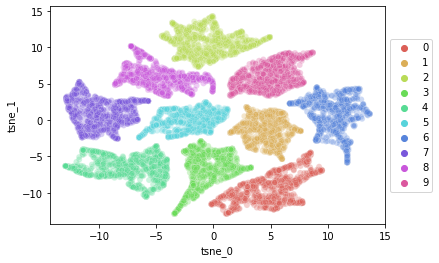

In [11]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [12]:
idx_9 = np.where(Label_full == 9)[0]
true_9_prop_df = Y_train.iloc[idx_9]
X_unkp_9 = X_full[idx_9,]


# **M1 Model Definition**

# **Model Definition**


## Hyperparameters

In [43]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 100 # 500 

alpha_rot = 1000000 #1000000
alpha_prop = 100 #100

beta_kl_slack = 0.5 # 10 ###
beta_kl_rot = 100 # 100 ###
beta_kl_prop = 10


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 6 "patients" 1 sample augmented into 6 distinct versions
n_drugs = n_drugs  # number of drugs one-hot encoded
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer 512 
decoder_dim = 512 # dim of encoder hidden layer 512 
decoder_out_dim = n_x # dim of decoder output layer

# labeled classifier
class_dim1 = 512 # 512 
class_dim2 = 256 # 256 


activ = 'relu'
optim = Adam(learning_rate=0.0005) #0.001

print(f"length of X {n_x} and length of y {n_y} n_label {n_label} and n_drugs {n_drugs}")

length of X 5999 and length of y 7 n_label 10 and n_drugs 2


## Encoder + Y classifier

In [44]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
Y = Input(shape=(n_y,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))
z_in = Input(shape=(n_y+n_label_z+n_label_z,))
cls_in = Input(shape=(n_label_z,))

inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(inputs)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_label_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_label_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)



# set up labeled classifier
#defining the architecture of the classifier

class_hidden1 = Dense(class_dim1, activation=activ, name = "cls_h1")
class_hidden2 = Dense(class_dim2, activation=activ, name="cls_h2")
class_out = Dense(n_y, activation='softmax', name="cls_out")

#x_concat_lab = tf.keras.layers.concatenate([inputs, label])
#classifier_h1 = class_hidden1(tf.keras.layers.Concatenate()([inputs, label]))
classifier_h1 = class_hidden1(inputs)
classifier_h2 = class_hidden2(classifier_h1)
Y_cls = class_out(classifier_h2)



## Latent Space

In [45]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_label_z])
z_rot = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])

z_concat_lab = concat([z_slack, Y, z_rot])
z_concat_unlab = concat([z_slack, Y_cls, z_rot])

## Decoder + Classifiers

In [46]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

d_in = Input(shape=(n_label_z+n_y+n_label_z,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)

# set up the decoder part that links to the encoder
# labeled decoder
h_lab = decoder_hidden(z_concat_lab)
outputs_lab = decoder_out(h_lab)

# unlabeled decoder
h_unlab = decoder_hidden(z_concat_unlab)
outputs_unlab = decoder_out(h_unlab)


###### Rotations classifier
# this is the rotation we try to estimate
rot_h1 = ReLU(name = "rot_h1")
rot_h2 = Dense(n_label, activation='linear', name = "rot_h2")
rot_softmax = Softmax(name = "mu_rot_pred")
decoder_sigma_r = Lambda(null_f, name = "l_sigma_rot_pred")


rot_1_out = rot_h1(z_rot)
rot_2_out = rot_h2(rot_1_out)
rotation_outputs = rot_softmax(rot_2_out)
sigma_outputs_r = decoder_sigma_r(l_sigma_rot)








## Loss

In [47]:

def vae_loss(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_rot + kl_slack


def recon_loss(y_true, y_pred):
	return K.sum(mean_squared_error(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_prop


def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)*alpha_rot
    return recon



## Make the computational graph

In [48]:
classifier = Model(X, Y_cls)

known_prop_vae = Model([X, Y], [outputs_lab, Y_cls, rotation_outputs])
unknown_prop_vae = Model(X, [outputs_unlab, rotation_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, class_loss]) #, metrics = [KL_loss, recon_loss])

encoder_unlab = Model(X, [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot])

encoder_lab = Model([X, Y], [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot])


decoder = Model(d_in, d_out)


print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 5999)]       0                                            
__________________________________________________________________________________________________
encoder_slack (Dense)           (None, 512)          3072000     input_7[0][0]                    
__________________________________________________________________________________________________
encoder_rot (Dense)             (None, 512)          3072000     input_7[0][0]                    
__________________________________________________________________________________________________
sigma_slack (Dense)             (None, 64)           32832       encoder_slack[0][0]              
____________________________________________________________________________________________

In [141]:
display(plot_model(known_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


None

In [50]:
display(plot_model(unknown_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


None

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [51]:


def fit_model(X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, epochs):
    assert len(X_unknown_prop) % len(X_known_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    meta_hist = []
    
    for epoch in range(epochs):
        unlabeled_index = np.arange(len(X_unknown_prop))
        np.random.shuffle(unlabeled_index)

        # Repeat the unlabeled data to match length of labeled data
        labeled_index = []
        for i in range(len(X_unknown_prop) // len(X_known_prop)):
            l = np.arange(len(X_known_prop))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        for i in range(batches):
            # Labeled
            index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
            loss = known_prop_vae.train_on_batch([X_known_prop[index_range], Y_known_prop[index_range]],
                                                    [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range]])
            meta_hist.append(i)

            # Unlabeled
            index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
            loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range],
                                                        [X_unknown_prop[index_range], label_unknown_prop[index_range]])]

            meta_hist.append(i)

            history.append(loss)
            
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return [history, meta_hist]

Now train

In [52]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


In [53]:
# X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop
loss_history = fit_model(X_unkp,
                    label_unkp,
                    X_kp, 
                    y_kp,
                    label_kp, epochs=n_epoch)

print(X_0[0].shape) 
print(y_0[0].shape)



Elapsed:  1230.9860937595367
(5999,)
(7,)


In [54]:
meta_history = loss_history[1]
loss_history = loss_history[0]

# Plot Loss Curves

In [55]:
# write out the loss for later plotting
# unpack the loss values
labeled_total_loss = [item[0] for item in loss_history]
unlabeled_total_loss = [item[4][0] for item in loss_history]

labeled_recon_loss = [item[1] for item in loss_history]
unlabeled_recon_loss = [item[4][1] for item in loss_history]

labeled_prop_loss = [item[2] for item in loss_history]

labeled_samp_loss = [item[3] for item in loss_history]
unlabeled_samp_loss = [item[4][2] for item in loss_history]


# make into a dataframe
total_loss = labeled_total_loss + unlabeled_total_loss + [a + b for a, b in zip(labeled_total_loss, unlabeled_total_loss)]
loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
loss_df['type'] = ["labeled"]*len(loss_history) + ["unlabeled"]*len(loss_history) + ["sum"]*len(loss_history)
loss_df['batch'] = [*range(len(loss_history))] + [*range(len(loss_history))] + [*range(len(loss_history))]

recon_loss = labeled_recon_loss + unlabeled_recon_loss + [a + b for a, b in zip(labeled_recon_loss, unlabeled_recon_loss)]
loss_df['recon_loss'] = recon_loss

prop_loss = labeled_prop_loss + [0]*len(loss_history) + labeled_prop_loss
loss_df['prop_loss'] = prop_loss

samp_loss = labeled_samp_loss + unlabeled_samp_loss + [a + b for a, b in zip(labeled_samp_loss, unlabeled_samp_loss)]
loss_df['samp_loss'] = samp_loss



In [56]:
loss_df

total_loss     type  batch    recon_loss    prop_loss     samp_loss
0      4.627658e+06  labeled      0  20510.283203  7952.985352  4.599194e+06
1      1.121482e+06  labeled      1  20554.048828  7947.772949  1.092980e+06
2      6.191063e+05  labeled      2  25424.011719  7952.137695  5.857302e+05
3      3.744551e+05  labeled      3  29805.531250  8021.295898  3.366282e+05
4      2.663094e+05  labeled      4  34743.839844  7897.141113  2.236684e+05
...             ...      ...    ...           ...          ...           ...
11995  7.125185e+03      sum   3995   6237.453125   262.899963  6.248320e+02
11996  7.203336e+03      sum   3996   6166.252930   328.472229  7.086109e+02
11997  7.096676e+03      sum   3997   6276.972656   290.791931  5.289111e+02
11998  7.174082e+03      sum   3998   6291.542969   357.825104  5.247131e+02
11999  7.509948e+03      sum   3999   6247.403320   355.430878  9.071139e+02

[12000 rows x 6 columns]

In [57]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

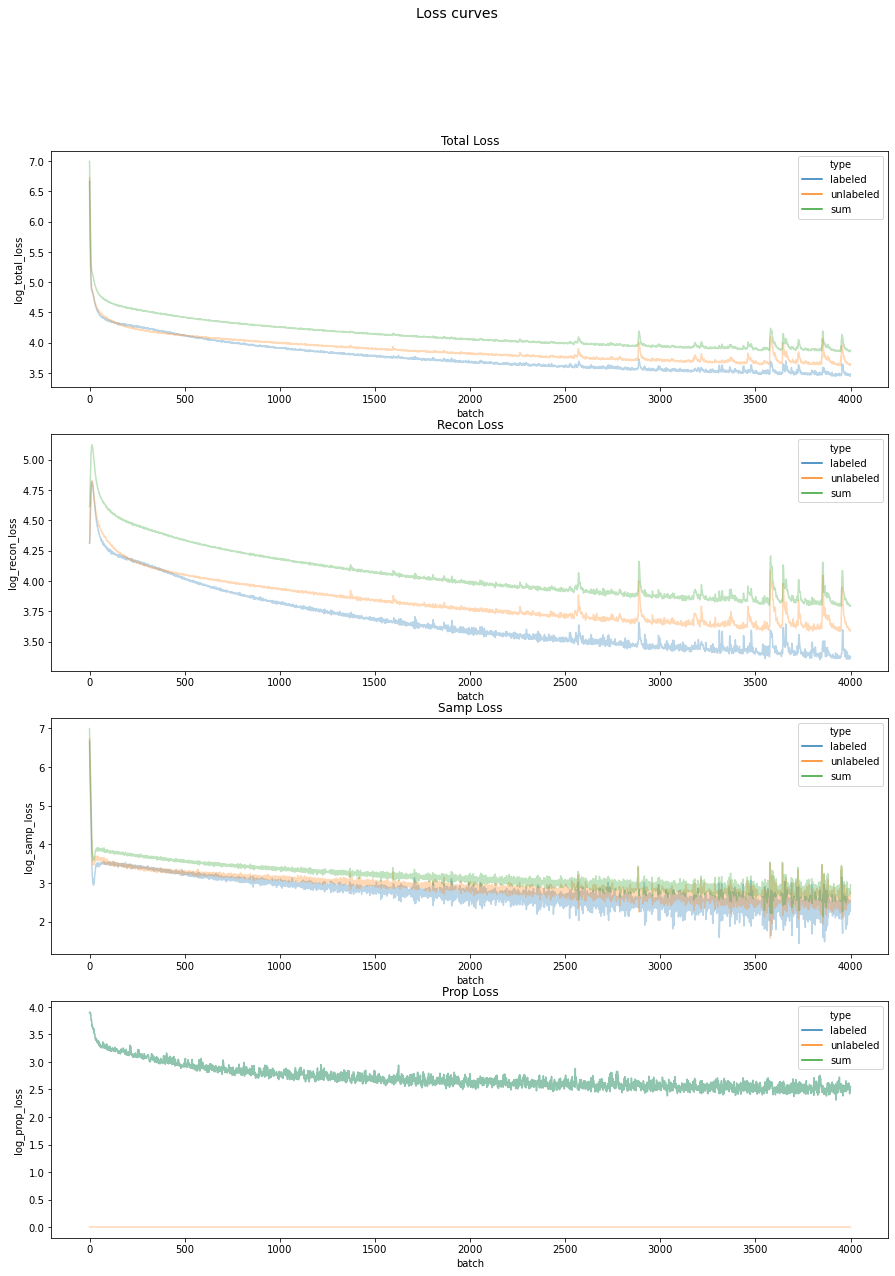

In [58]:
fig, axs = plt.subplots(4, figsize=(15,20))

loss_df["log_total_loss"] = np.log10(loss_df["total_loss"]+1)
loss_df["log_recon_loss"] = np.log10(loss_df["recon_loss"]+1)
loss_df["log_samp_loss"] = np.log10(loss_df["samp_loss"]+1)
loss_df["log_prop_loss"] = np.log10(loss_df["prop_loss"]+1)

make_loss_fig(loss_df, ax=axs[0], title=f"Total Loss", loss_to_plot="log_total_loss")
make_loss_fig(loss_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="log_recon_loss")
make_loss_fig(loss_df, ax=axs[2], title=f"Samp Loss", loss_to_plot="log_samp_loss")
make_loss_fig(loss_df, ax=axs[3], title=f"Prop Loss", loss_to_plot="log_prop_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

In [59]:
loss_df

total_loss     type  batch    recon_loss    prop_loss     samp_loss  \
0      4.627658e+06  labeled      0  20510.283203  7952.985352  4.599194e+06   
1      1.121482e+06  labeled      1  20554.048828  7947.772949  1.092980e+06   
2      6.191063e+05  labeled      2  25424.011719  7952.137695  5.857302e+05   
3      3.744551e+05  labeled      3  29805.531250  8021.295898  3.366282e+05   
4      2.663094e+05  labeled      4  34743.839844  7897.141113  2.236684e+05   
...             ...      ...    ...           ...          ...           ...   
11995  7.125185e+03      sum   3995   6237.453125   262.899963  6.248320e+02   
11996  7.203336e+03      sum   3996   6166.252930   328.472229  7.086109e+02   
11997  7.096676e+03      sum   3997   6276.972656   290.791931  5.289111e+02   
11998  7.174082e+03      sum   3998   6291.542969   357.825104  5.247131e+02   
11999  7.509948e+03      sum   3999   6247.403320   355.430878  9.071139e+02   

       log_total_loss  log_recon_loss  log_samp_loss  log_prop_loss  
0            6.665361        4.311993       6.662682       3.900585  
1            6.049793        4.312919       6.038613       3.900300  
2            5.791766        4.405261       5.767698       3.900539  
3            5.573401        4.474311       5.527152       3.904299  
4            5.425388        4.540890       5.349607       3.897525  
...               ...             ...            ...            ...  
11995        3.852857        3.795077       2.796458       2.421439  
11996        3.857594        3.790092       2.851020       2.517819  
11997        3.851116        3.797819       2.724203       2.465073  
11998        3.855827        3.798826       2.720749       2.554883  
11999        3.875695        3.795769       2.958140       2.551975  

[12000 rows x 10 columns]

In [60]:
loss_df.iloc[np.where(loss_df["batch"] > 2547)[0]] # 2547

total_loss     type  batch   recon_loss   prop_loss   samp_loss  \
2548   3911.107178  labeled   2548  3063.451904  384.580811  463.074432   
2549   4016.576904  labeled   2549  3128.461426  365.526733  522.588562   
2550   3950.831055  labeled   2550  3290.151367  350.945953  309.733582   
2551   4165.519043  labeled   2551  3353.331299  565.516296  246.671432   
2552   3992.664307  labeled   2552  3273.345459  349.611633  369.707306   
...            ...      ...    ...          ...         ...         ...   
11995  7125.184570      sum   3995  6237.453125  262.899963  624.832031   
11996  7203.335938      sum   3996  6166.252930  328.472229  708.610901   
11997  7096.675781      sum   3997  6276.972656  290.791931  528.911133   
11998  7174.082031      sum   3998  6291.542969  357.825104  524.713135   
11999  7509.948242      sum   3999  6247.403320  355.430878  907.113892   

       log_total_loss  log_recon_loss  log_samp_loss  log_prop_loss  
2548         3.592411        3.486353       2.666588       2.586115  
2549         3.603964        3.495470       2.718990       2.564106  
2550         3.596798        3.517348       2.492388       2.546476  
2551         3.619773        3.525606       2.393876       2.753212  
2552         3.601372        3.515125       2.569031       2.544826  
...               ...             ...            ...            ...  
11995        3.852857        3.795077       2.796458       2.421439  
11996        3.857594        3.790092       2.851020       2.517819  
11997        3.851116        3.797819       2.724203       2.465073  
11998        3.855827        3.798826       2.720749       2.554883  
11999        3.875695        3.795769       2.958140       2.551975  

[4356 rows x 10 columns]

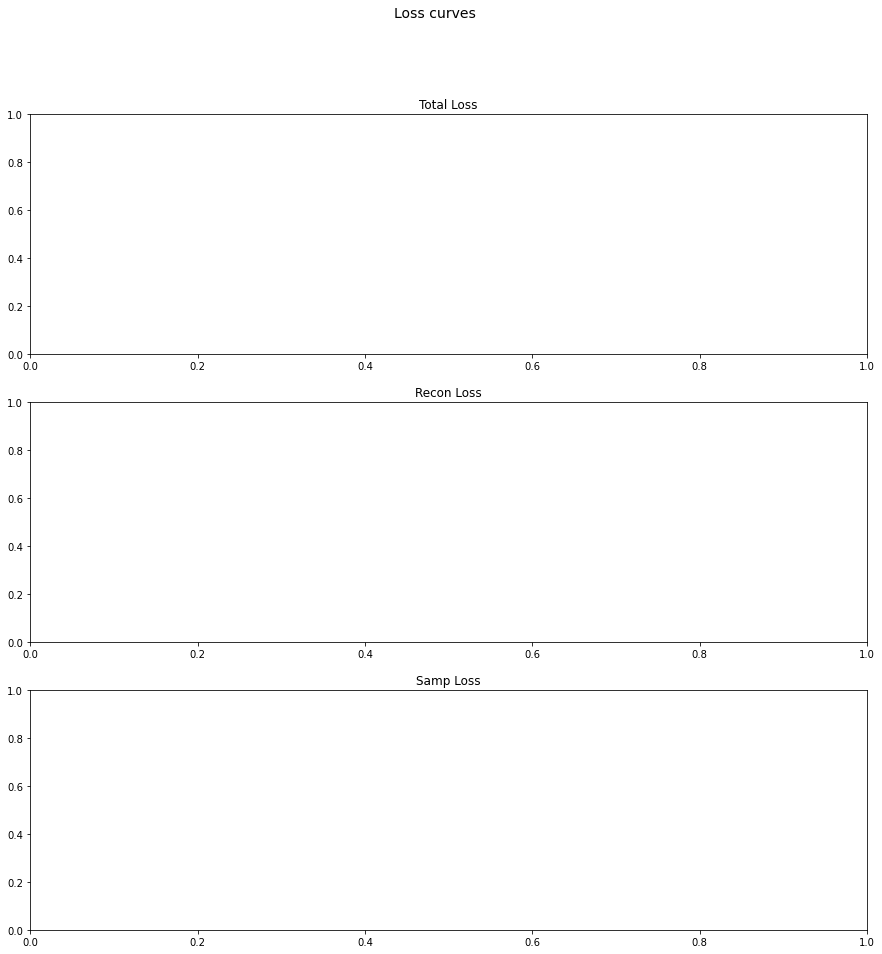

In [61]:
fig, axs = plt.subplots(3, figsize=(15,15))


top_loss = np.where(np.logical_and(loss_df["batch"] > 7000, loss_df["batch"] < 9000))[0]
top_loss = loss_df.iloc[top_loss]


make_loss_fig(top_loss, ax=axs[0], title=f"Total Loss", loss_to_plot="log_total_loss")
make_loss_fig(top_loss, ax=axs[1], title=f"Recon Loss", loss_to_plot="log_recon_loss")
make_loss_fig(top_loss, ax=axs[2], title=f"Samp Loss", loss_to_plot="log_samp_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

In [62]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


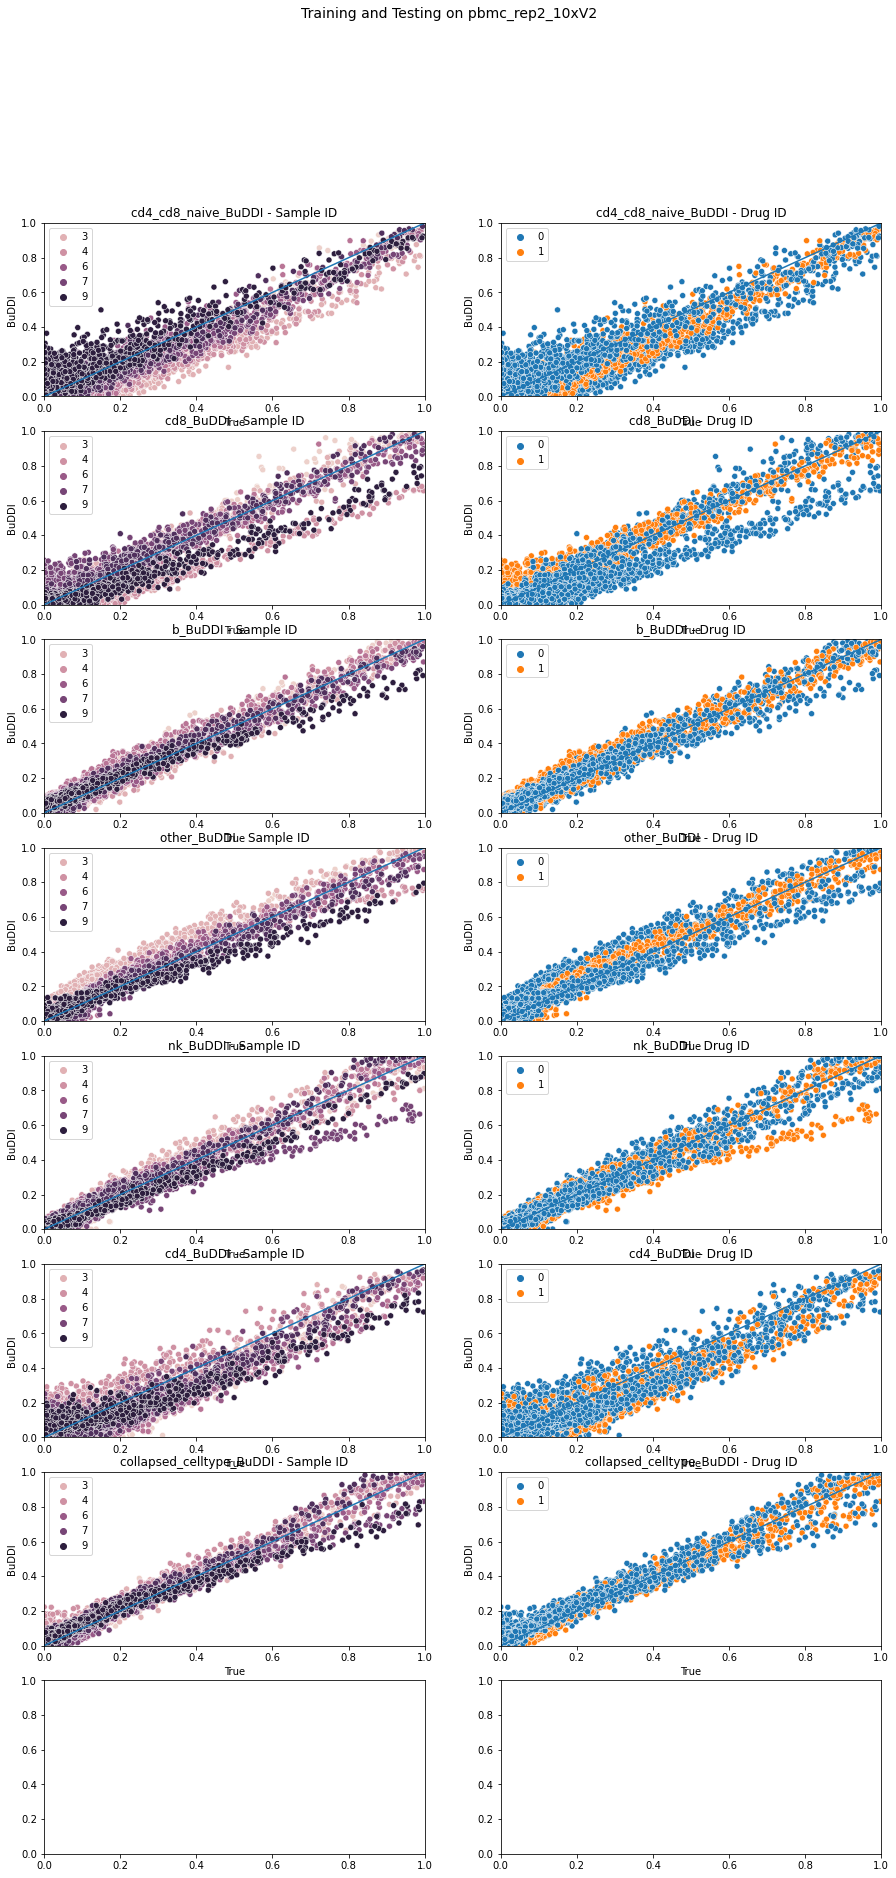

In [63]:
idx_tmp = np.where(Label_full >= 2)[0]
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_tmp]

fig, axs = plt.subplots(8, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

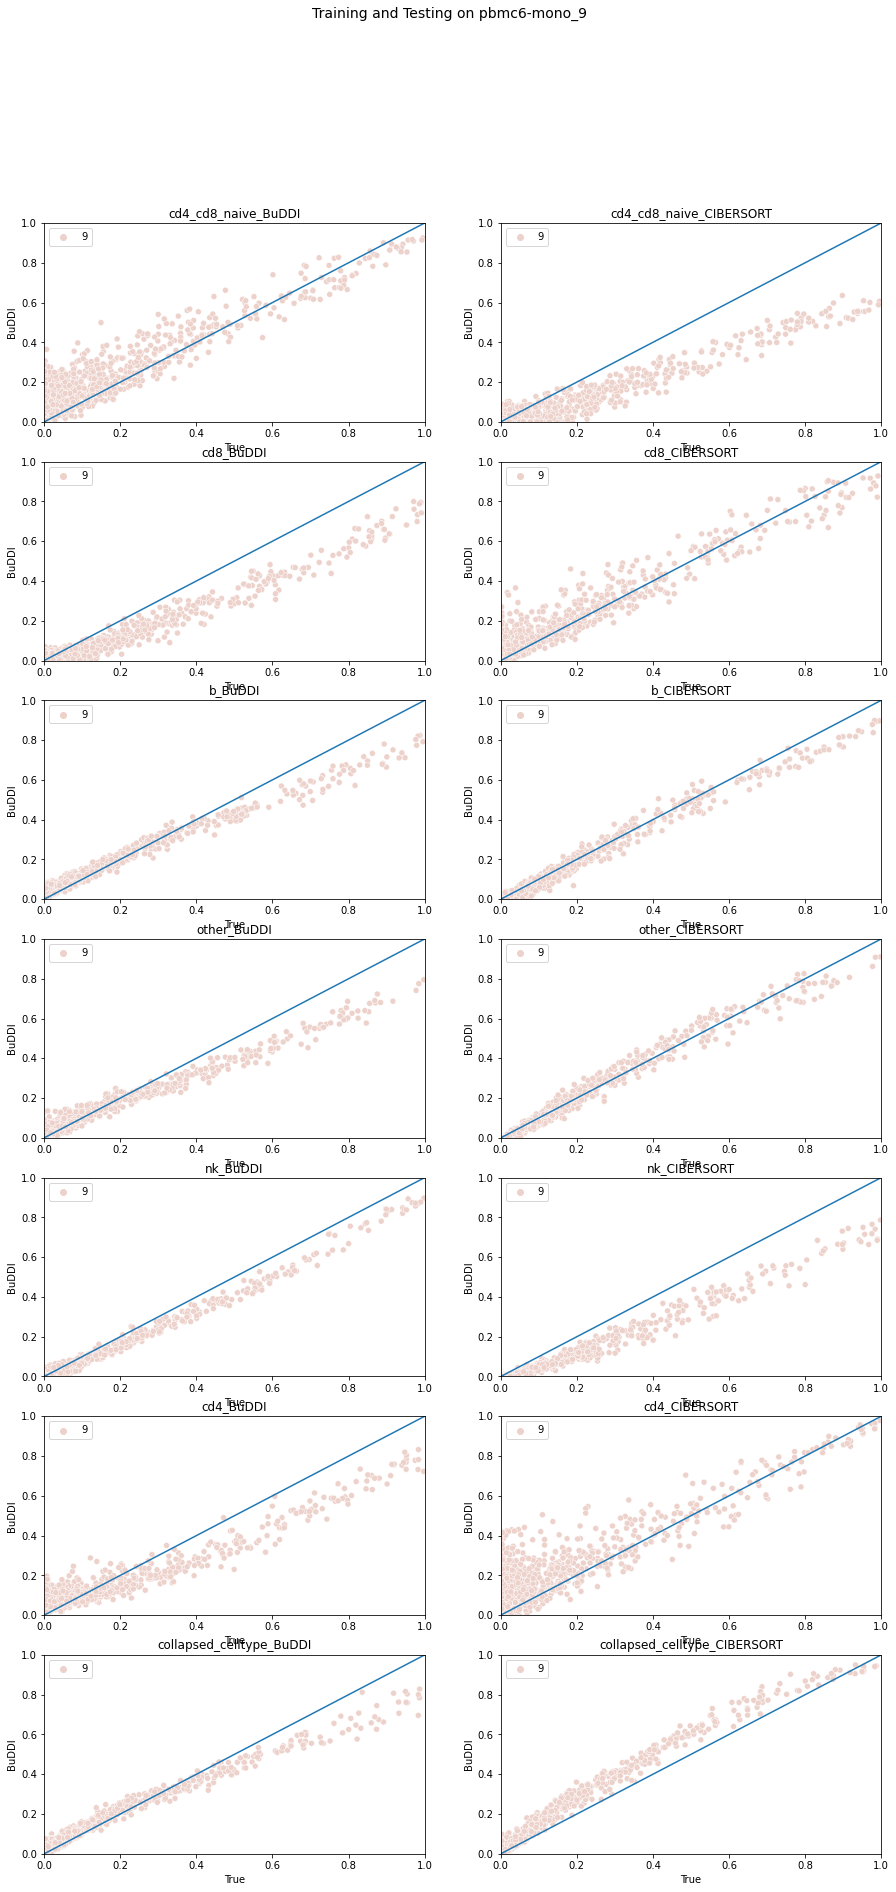

In [64]:
idx_9 = np.where(Label_full == 9)[0]
true_9_prop_df = Y_train.iloc[idx_9]
X_unkp_9 = X_full[idx_9,]

# read in cibersort
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_pbmc/pbmc6k-mono_9_1_cybersort_mix_CIBERSORTx_Job11_Results.csv"
cibersort_df = pd.read_csv(cibersort_file_path)
cibersort_df = cibersort_df.reindex(columns=Y_train.columns, fill_value=0)

# make predictions
prop_outputs = classifier.predict(X_unkp_9, batch_size=batch_size)

## plot for the unlabeled
prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_9]



fig, axs = plt.subplots(7, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI", class_id=Label_full[idx_9])
    plot_cell_specific_corr(true_prop_df[curr_cell], cibersort_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_CIBERSORT", xlab="True", ylab="BuDDI", class_id=Label_full[idx_9])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc6-mono_9", fontsize=14)

fig.show()

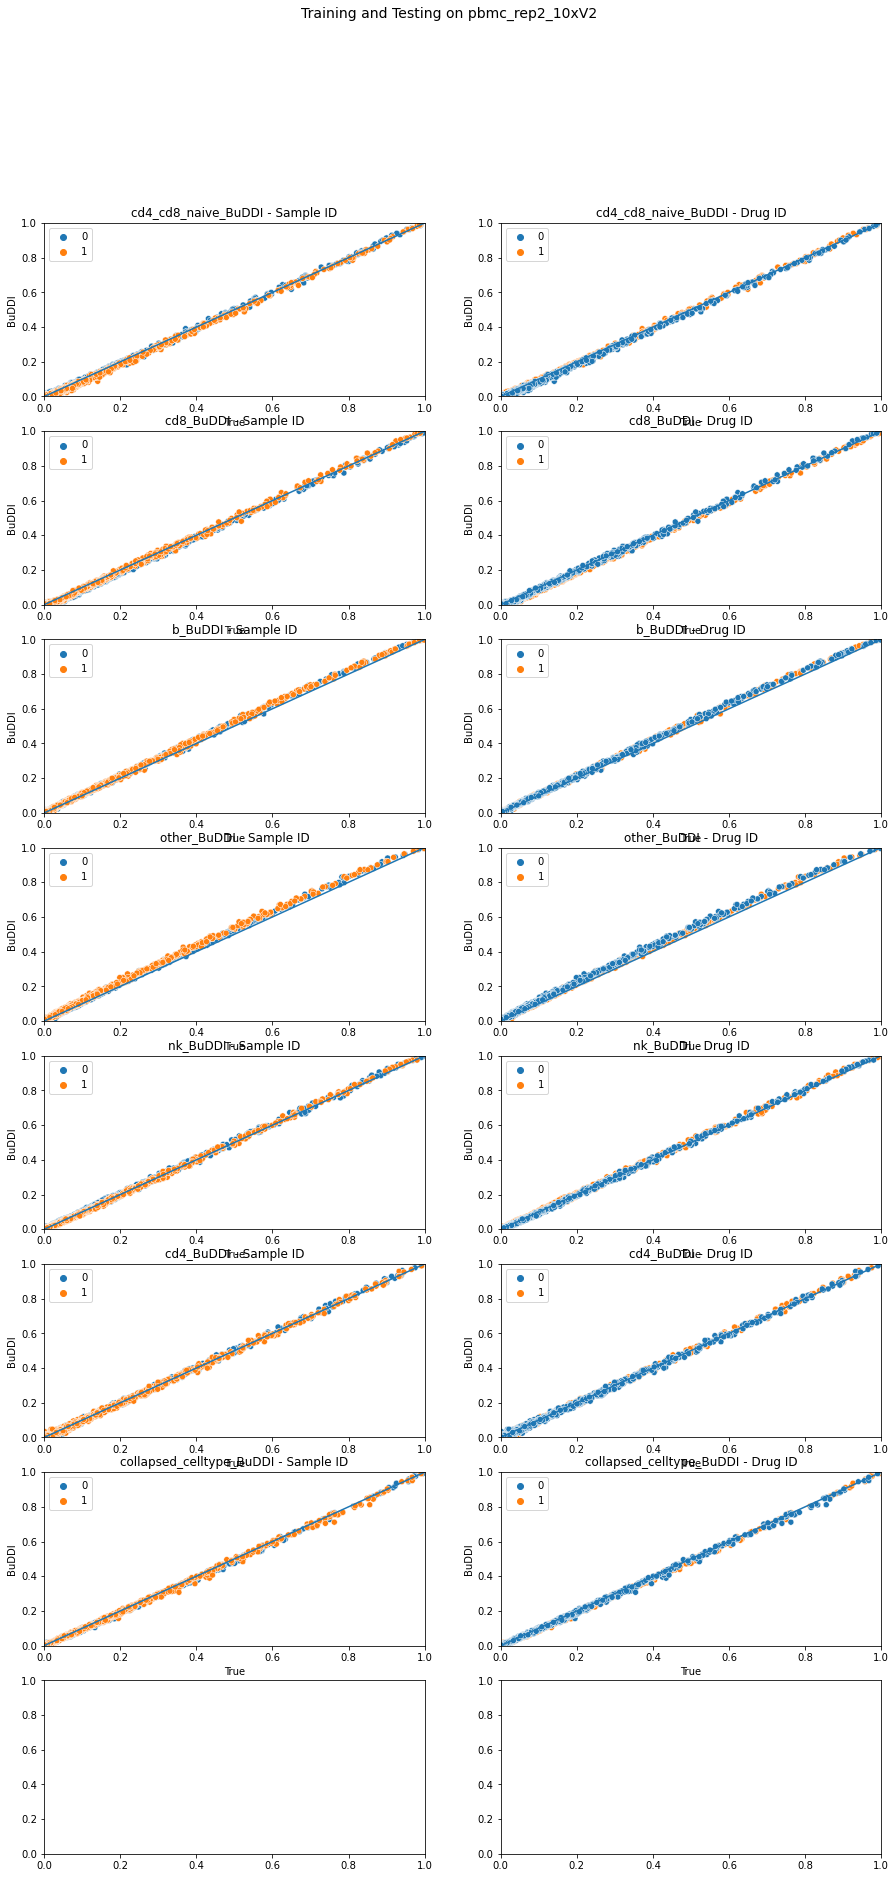

In [65]:
# make predictions
prop_outputs = classifier.predict(X_kp, batch_size=batch_size)


## plot for the labeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_train]

fig, axs = plt.subplots(8, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_train])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_train])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

In [318]:
import umap

def get_umap_for_plotting(encodings):
    fit = umap.UMAP()
    umap_results = fit.fit_transform(encodings)

    plot_df = pd.DataFrame(umap_results[:,0:2])
    print(umap_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['umap_0', 'umap_1']
    return plot_df

def plot_umap(plot_df, color_vec, ax, title, alpha=0.3):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="umap_0", y="umap_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=alpha, ax= ax
    )

    ax.set_title(title)
    return g


In [67]:
def get_tsne_for_plotting(encodings):
    tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
    tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g


In [111]:

def get_pca_for_plotting(encodings):
    fit = PCA(n_components=2)
    pca_results = fit.fit_transform(encodings)

    plot_df = pd.DataFrame(pca_results[:,0:2])
    print(pca_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['PCA_0', 'PCA_1']
    return plot_df

def plot_pca(plot_df, color_vec, ax, title):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="PCA_0", y="PCA_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.1, ax= ax
    )

    ax.set_title(title)
    return g

In [129]:
#batch_size = 4000
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

X_temp = np.copy(X_full)
X_temp = scale(X_temp, axis=1)

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
source_temp = np.asarray([0]*10000)

print(f"Number unique Y: {len(np.unique(Y_temp))}")


outputs_unlab, rotation_outputs = unknown_prop_vae.predict(X_temp, batch_size=batch_size)
Y_pred = classifier.predict(X_temp, batch_size=batch_size)
outputs_lab, y_pred_lab, rot_pred_lab = known_prop_vae.predict([X_temp, Y_pred], batch_size=batch_size)


Number unique Y: 7


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [106]:
label_temp == 0

array([ True,  True,  True, ..., False, False, False])

(10000, 2)
(10000, 2)


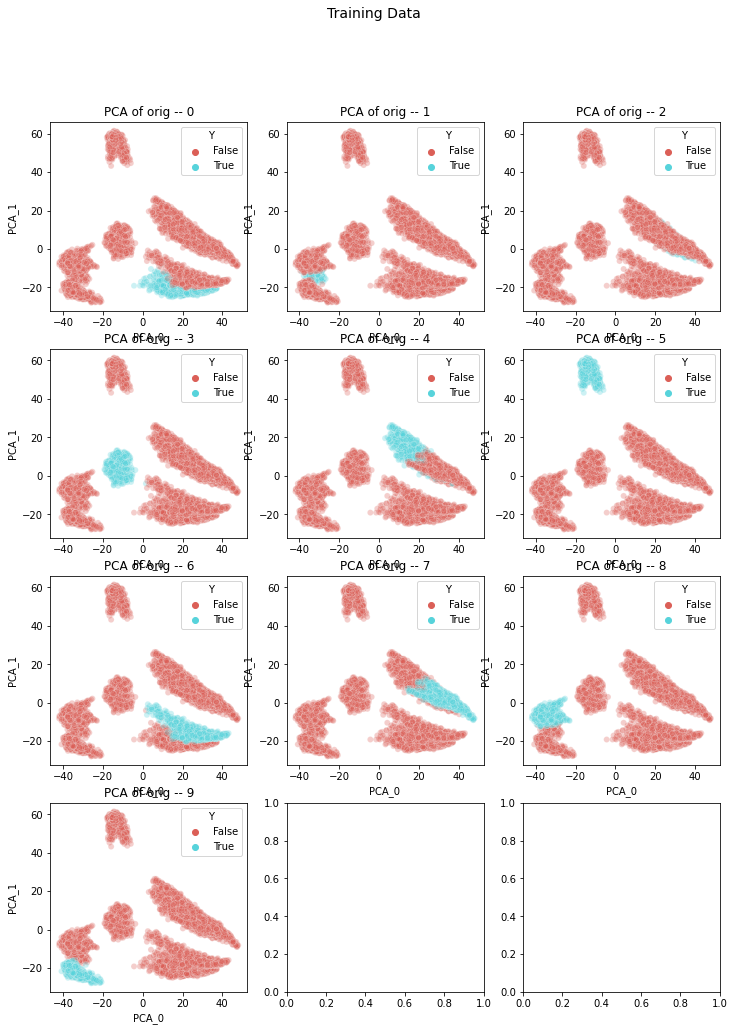

In [109]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = get_pca_for_plotting(np.asarray(X_temp))
plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of orig -- 0")
plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of orig -- 1")
plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of orig -- 2")
plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of orig -- 3")
plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of orig -- 4")
plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of orig -- 5")
plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of orig -- 6")
plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of orig -- 7")
plot_pca(plot_df, color_vec=label_temp==8, ax=axs[2,2], title="PCA of orig -- 8")
plot_pca(plot_df, color_vec=label_temp==9, ax=axs[3,0], title="PCA of orig -- 9")


fig.suptitle("Training Data", fontsize=14)

fig.show()

(10000, 2)
(10000, 2)


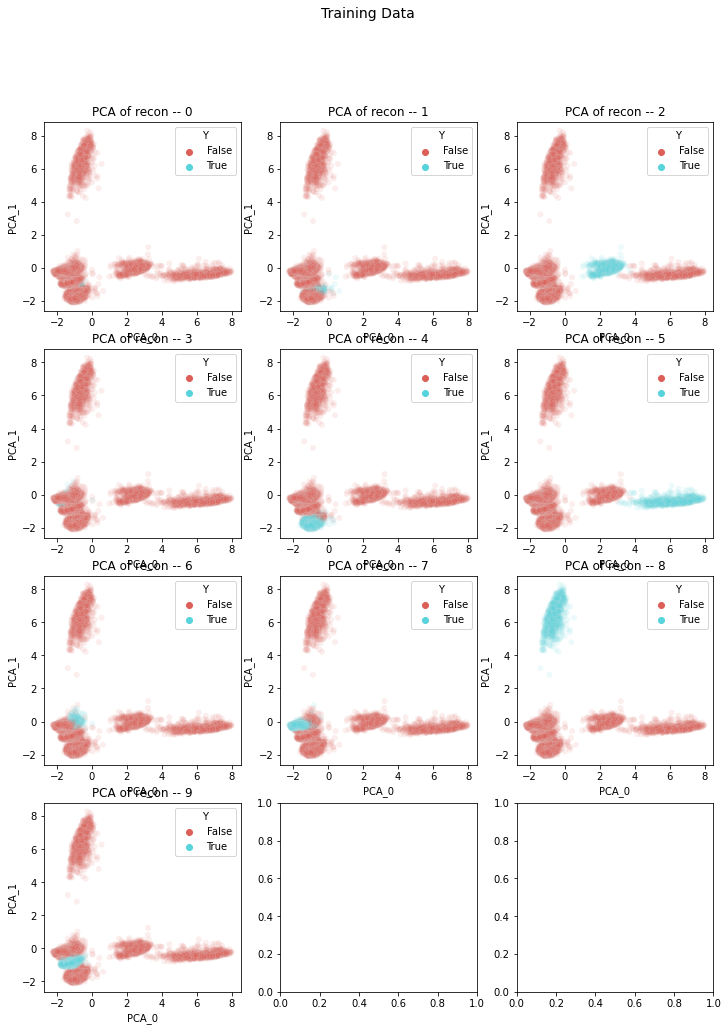

In [130]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = get_pca_for_plotting(np.asarray(outputs_lab))
plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of recon -- 0")
plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of recon -- 1")
plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of recon -- 2")
plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of recon -- 3")
plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of recon -- 4")
plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of recon -- 5")
plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of recon -- 6")
plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of recon -- 7")
plot_pca(plot_df, color_vec=label_temp==8, ax=axs[2,2], title="PCA of recon -- 8")
plot_pca(plot_df, color_vec=label_temp==9, ax=axs[3,0], title="PCA of recon -- 9")


fig.suptitle("Training Data", fontsize=14)

fig.show()

In [133]:
np.corrcoef(outputs_lab[1], outputs_unlab[1])

array([[1.        , 0.99725045],
       [0.99725045, 1.        ]])

In [114]:
outputs_unlab

array([[4.9461232e-06, 2.2804737e-04, 4.3854211e-06, ..., 4.4835178e-06,
        4.9181740e-06, 4.9330883e-06],
       [4.7982348e-07, 4.8179107e-05, 4.2611188e-07, ..., 5.7174935e-07,
        4.6068189e-07, 3.9451550e-07],
       [4.5829543e-07, 1.0071036e-05, 8.2314239e-07, ..., 5.1288004e-07,
        6.9390944e-07, 4.3413016e-07],
       ...,
       [1.0546150e-06, 1.2302101e-03, 1.0410528e-06, ..., 1.3750471e-06,
        1.2703034e-06, 1.4052438e-06],
       [6.8581340e-07, 5.4058433e-03, 9.4573664e-07, ..., 8.8023484e-07,
        1.0170173e-06, 8.5616534e-07],
       [4.6681424e-07, 6.5015852e-03, 6.5461739e-07, ..., 5.7701180e-07,
        7.3857399e-07, 8.9008773e-07]], dtype=float32)

(20000, 2)
(20000, 2)


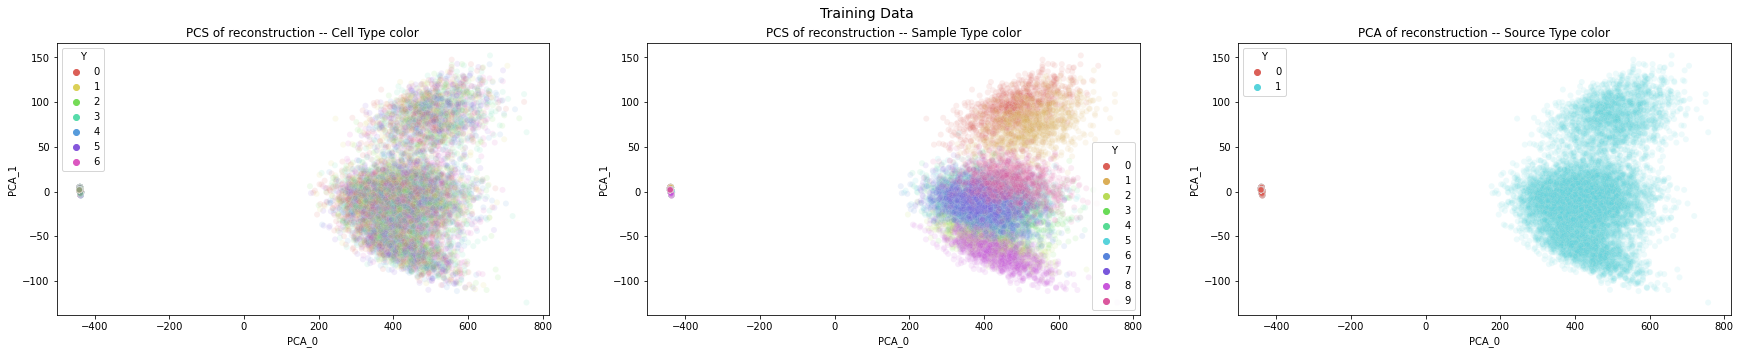

In [118]:
# make duplicated
X_dup = np.vstack([X_temp, np.log(outputs_unlab)])
Y_dup = np.append(Y_temp, Y_temp)
label_dup = np.append(label_temp, label_temp)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*10000, [1]*10000))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = get_pca_for_plotting(np.asarray(X_dup))
plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCS of reconstruction -- Cell Type color")
plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of reconstruction -- Sample Type color")
plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of reconstruction -- Source Type color")


fig.suptitle("Training Data", fontsize=14)

fig.show()

Number unique Y: 7
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


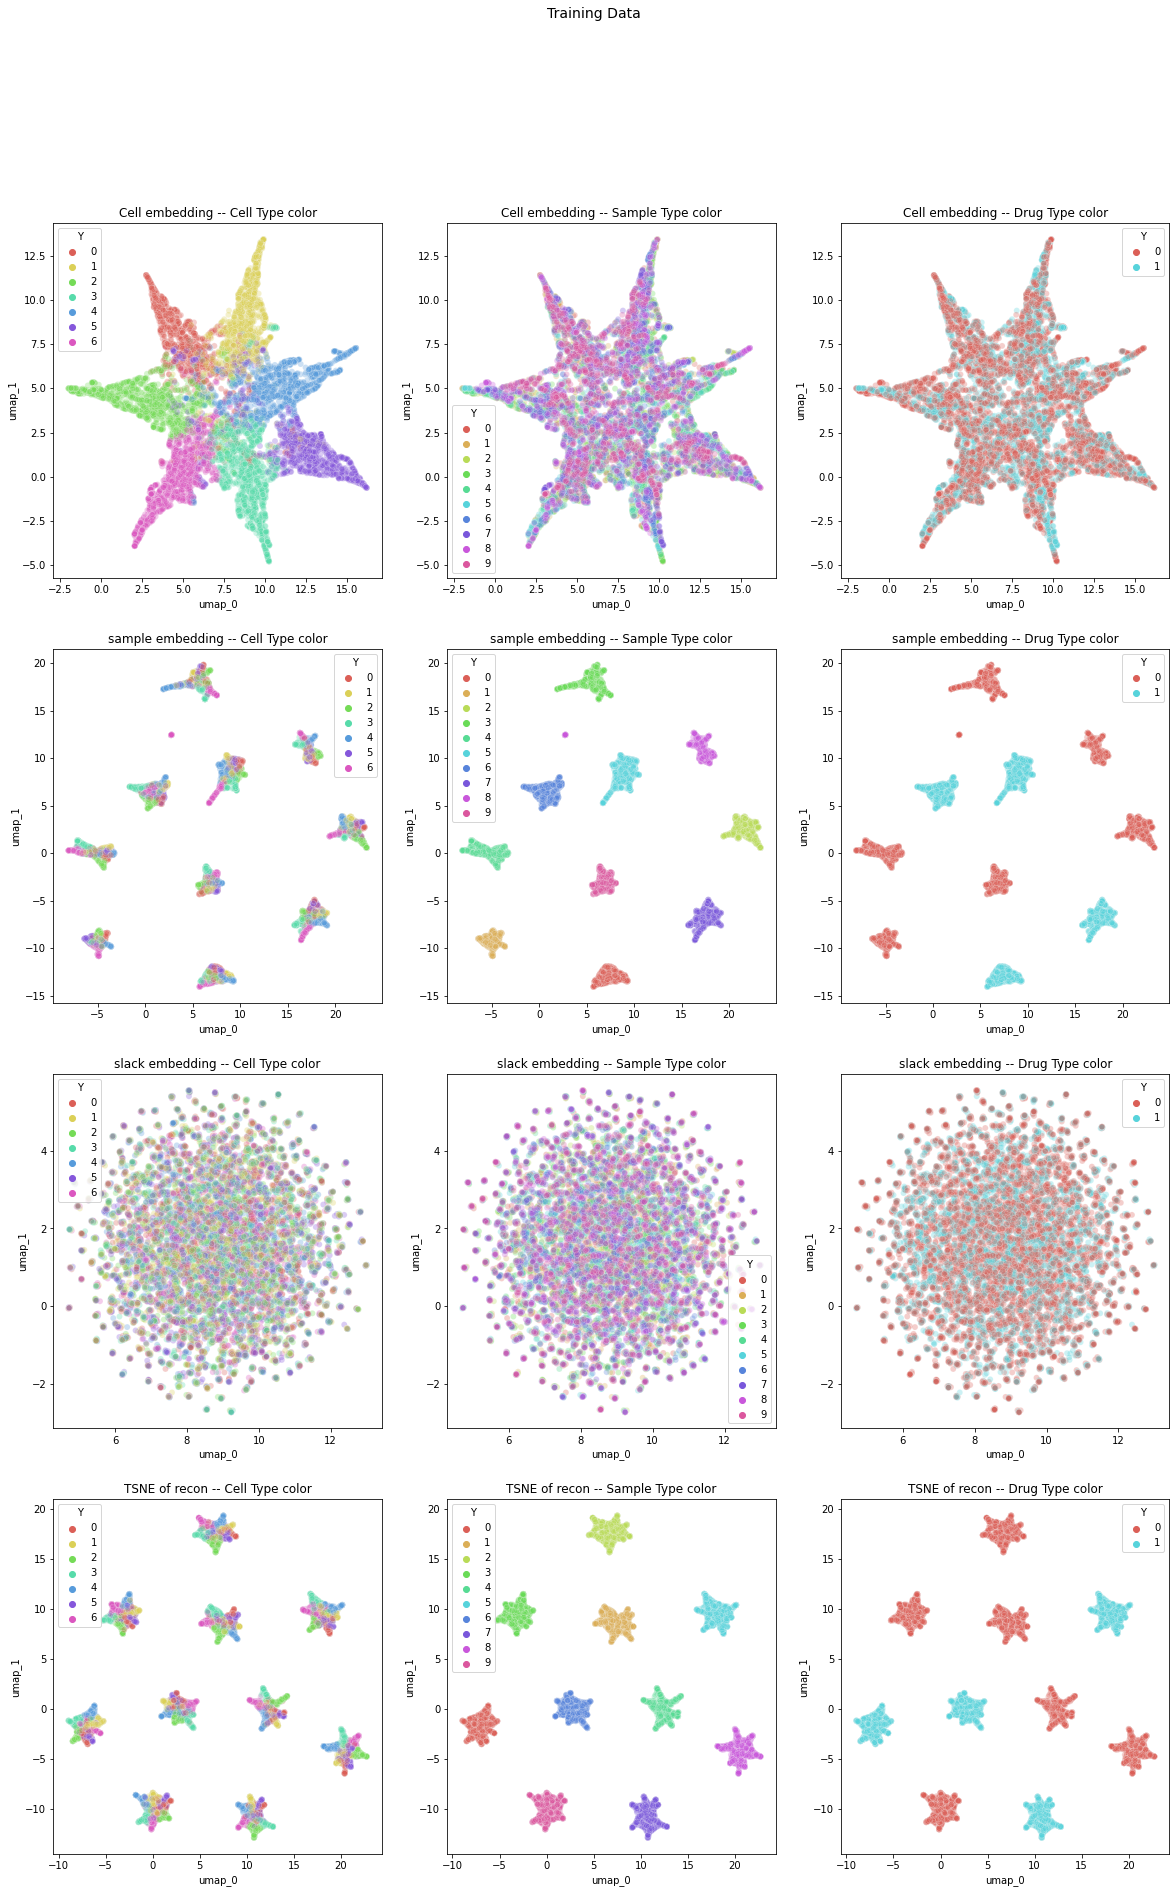

In [135]:
#batch_size = 4000
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

X_temp = np.copy(X_full)
X_temp = scale(X_temp, axis=1)

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = np.copy(Label_full)
perturb_temp = Drug_full

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)

outputs_unlab, rotation_outputs = unknown_prop_vae.predict(X_temp, batch_size=batch_size)


fig, axs = plt.subplots(4, 3, figsize=(20,30))

plot_df = get_umap_for_plotting(np.asarray(prop_outputs))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(mu_rot))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(mu_slack))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="slack embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(outputs_unlab))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[3,0], title="TSNE of recon -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[3,1], title="TSNE of recon -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

Number unique Y: 7
(10000, 2)
(10000, 2)


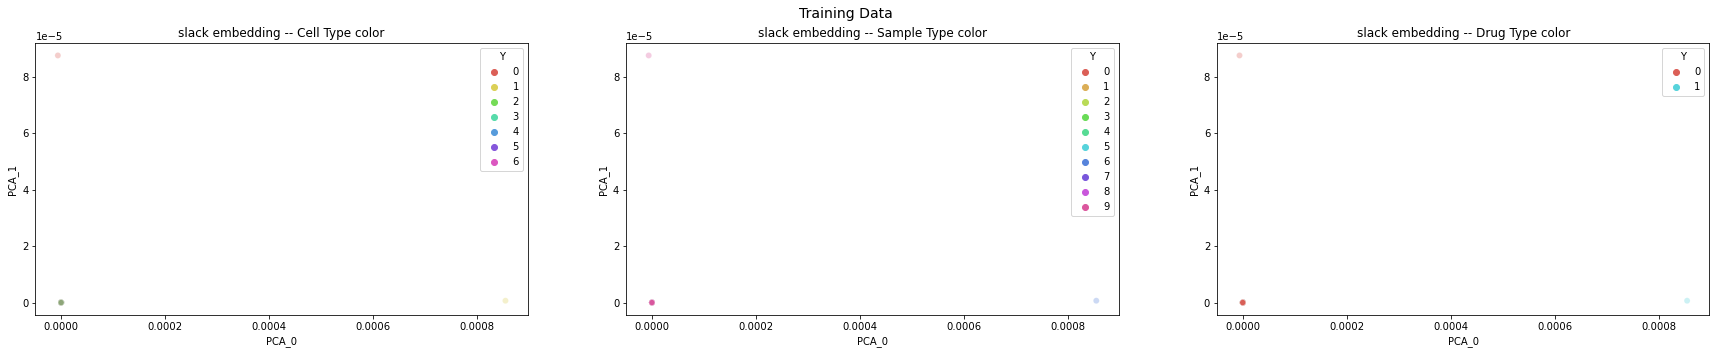

In [69]:


#batch_size = 500
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

X_temp = np.copy(X_full)
X_temp = scale(X_temp, axis=1)

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

label_temp = np.copy(Label_full)
perturb_temp = Drug_full

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = get_pca_for_plotting(np.asarray(mu_slack))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[0], title="slack embedding -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[1], title="slack embedding -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2], title="slack embedding -- Drug Type color")



fig.suptitle("Training Data", fontsize=14)

fig.show()

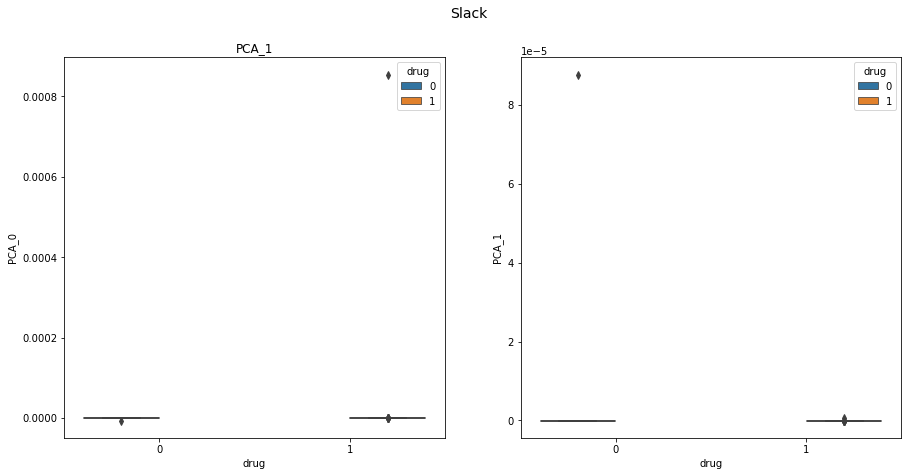

In [70]:
slack_df_pc = plot_df
slack_df_pc['drug'] = perturb_temp


fig, axs = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data=plot_df, 
            x="drug", y="PCA_0",
            hue="drug", ax= axs[0])
axs[0].set_title("PCA_1")

sns.boxplot(data=plot_df, 
            x="drug", y="PCA_1",
            hue="drug", ax= axs[1])
axs[0].set_title("PCA_1")

fig.suptitle("Slack", fontsize=14)

fig.show()


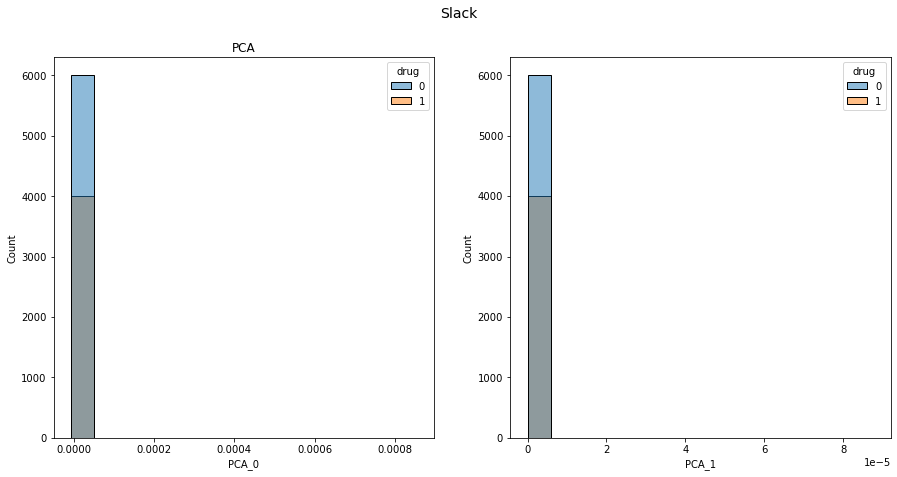

In [71]:

fig, axs = plt.subplots(1, 2, figsize=(15,7))
sns.histplot(data=plot_df, 
            x="PCA_0",
            hue="drug", ax= axs[0])
axs[0].set_title("PCA")

sns.histplot(data=plot_df, 
            x="PCA_1",
            hue="drug", ax= axs[1])
axs[0].set_title("PCA")

fig.suptitle("Slack", fontsize=14)

fig.show()

In [72]:
z_slack

array([[ 0.13505033,  1.6863261 ,  0.16297665, ...,  0.49674675,
         1.1227103 , -1.2372593 ],
       [-1.6290131 , -1.0490317 ,  0.24635929, ...,  0.03736109,
         0.5658032 ,  2.020506  ],
       [ 0.2387637 ,  2.5102916 ,  0.45427486, ..., -0.3565062 ,
        -1.6933091 ,  1.9035025 ],
       ...,
       [ 1.2041879 ,  0.41860774,  1.2068186 , ...,  0.347199  ,
        -0.92777306,  0.76492333],
       [ 0.02063394, -0.27046785, -0.41756353, ...,  1.7371212 ,
        -0.31406698, -0.58811545],
       [ 1.159964  , -0.90878814, -1.2956816 , ..., -1.3149257 ,
        -0.93328506, -0.27164757]], dtype=float32)

# Cell-Type Projections

In [303]:
# this is to generate noisy vector where the second elements is the largest
def add_vec_noise():
    a = np.random.lognormal(mean=0, sigma=1, size=7) + np.array([0,100,0,0,0,0,0])
    return a/a.sum()


array([[7.04980346e-03, 9.30525755e-01, 4.96666834e-04, 8.04619905e-03,
        1.10441353e-02, 2.10014277e-02, 2.18360129e-02],
       [6.54340392e-03, 8.39637042e-01, 5.00661428e-03, 2.72727741e-02,
        1.37816073e-02, 9.42967180e-02, 1.34618403e-02],
       [1.06820896e-02, 9.48236722e-01, 1.28074135e-03, 5.10221983e-03,
        1.09976255e-02, 1.51762417e-02, 8.52435997e-03]])

In [304]:
# now we will take one cell type and project it across different sample IDs.
# this will allow us to see how well the reconstruction does

X_temp = np.copy(X_full)
X_temp = scale(X_temp, axis=1)

# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = encoder_unlab.predict(X_temp, batch_size=batch_size)

# first take all the samples from patient 1 where cell_0 is the max
label_temp = np.copy(Label_full)
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
idx_0_patient = np.where(np.logical_and(label_temp == 0, Y_temp == 0))[0]

# and replace it with cell_1 -- with noise!
Y_1 = np.copy(Y_full)
noisy_prop_vec = [add_vec_noise() for i in range(len(idx_0_patient))]
noisy_prop_vec = np.vstack(noisy_prop_vec)

Y_1[idx_0_patient,] = noisy_prop_vec

# now concatenate together
z_concat_unlab_perturb = np.hstack([z_slack, Y_1, z_rot])

# and decode
decoded_0_1 = decoder.predict(z_concat_unlab_perturb, batch_size=batch_size)

# compare with original
z_concat_unlab_UNperturb = np.hstack([z_slack, Y_full, z_rot])
decoded_0_0 = decoder.predict(z_concat_unlab_UNperturb, batch_size=batch_size)




(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


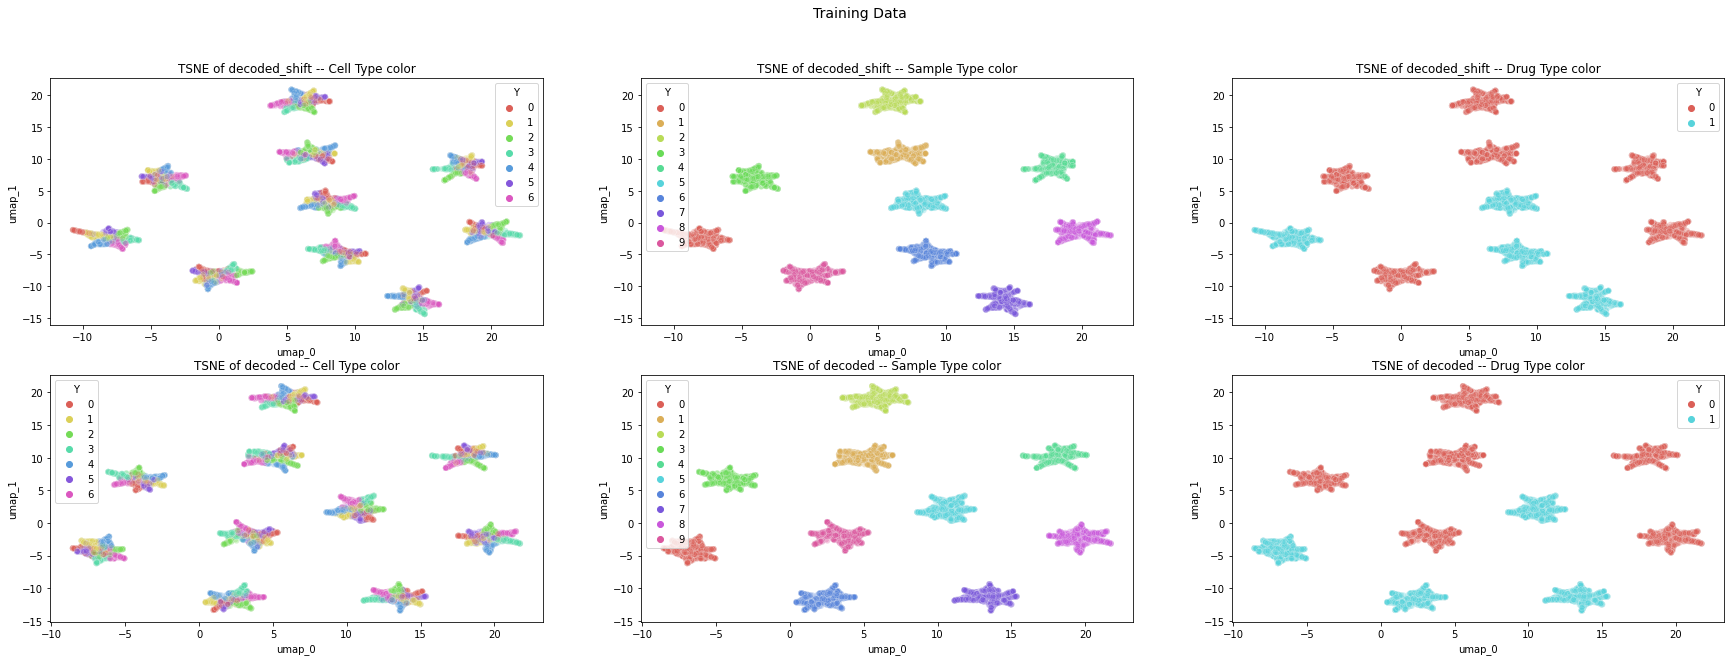

In [307]:

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

fig, axs = plt.subplots(2, 3, figsize=(30,10))

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="TSNE of decoded_shift -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_0))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="TSNE of decoded -- Drug Type color")


fig.suptitle("Training Data", fontsize=14)

fig.show()


(1000, 2)
(1000, 2)
(1000, 2)
(1000, 2)


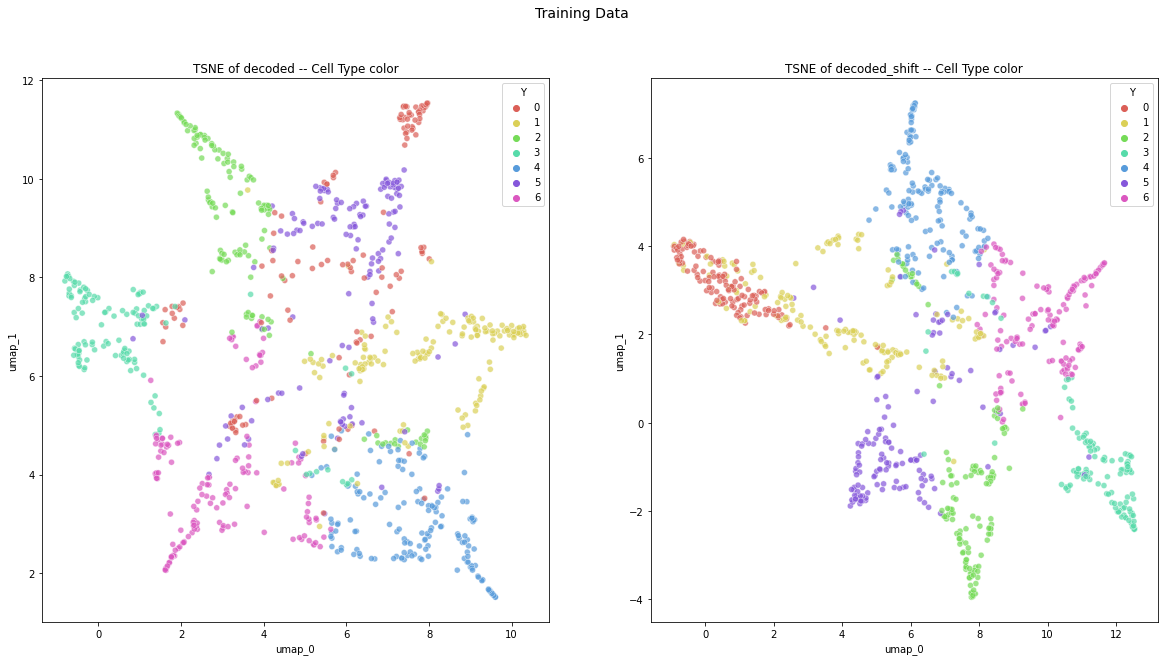

In [319]:

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

samp_0 = range(1000)

fig, axs = plt.subplots(1, 2, figsize=(20,10))


plot_df = get_umap_for_plotting(np.asarray(decoded_0_0[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[0], title="TSNE of decoded -- Cell Type color", alpha=0.7)

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[1], title="TSNE of decoded_shift -- Cell Type color", alpha=0.7)


fig.suptitle("Training Data", fontsize=14)

fig.show()




# Sample Projection

In [320]:
# now we will take one cell type and project it across different sample IDs.
# this will allow us to see how well the reconstruction does

X_temp = np.copy(X_full)
X_temp = scale(X_temp, axis=1)

# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = encoder_unlab.predict(X_temp, batch_size=batch_size)

# first take all the samples from patient 0 where cell_0 is the max
label_temp = np.copy(Label_full)
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
idx_0_patient = np.where(np.logical_and(label_temp == 0, Y_temp == 0))[0]

# and take a random set of the samples from patient 1 
# of the length of idx_0_patient
# this is because we will use this random sample as our translation
idx_1_patient = np.where(label_temp == 1,)[0]
idx_1_patient = np.random.choice(idx_1_patient, len(idx_0_patient))

# now for patient 0, cell type 0
# we are shifting it to patient 1 cell type 0
# cell type should remain the same because the latent spaces are
# disentangled and we are not changing Y
z_rot_perturb = np.copy(z_rot)
z_rot_perturb[idx_0_patient,] = z_rot_perturb[idx_1_patient,]

# now concatenate together and decode
z_concat_unlab_perturb = np.hstack([z_slack, Y_full, z_rot_perturb])
decoded_0_1 = decoder.predict(z_concat_unlab_perturb, batch_size=batch_size)

# compare with original
z_concat_unlab_UNperturb = np.hstack([z_slack, Y_full, z_rot])
decoded_0_0 = decoder.predict(z_concat_unlab_UNperturb, batch_size=batch_size)




In [334]:
plot_df.iloc[only_cell_0_interest]

umap_0     umap_1  Y
7    -7.774398  -4.282156  0
10   -7.044794  -4.111979  0
25   -7.995845  -4.069004  0
43   -8.615315  -3.216736  0
44   -8.997400  -4.083705  0
...        ...        ... ..
1976  6.819206  10.084020  1
1982  5.301547  10.639884  1
1984  6.913991   9.222029  1
1986  6.799428  10.056379  1
1995  6.917447   9.323581  1

[268 rows x 3 columns]

(10000, 2)
(10000, 2)


/tmp/ipykernel_7122/1232243567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


(10000, 2)
(10000, 2)


/tmp/ipykernel_7122/1232243567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


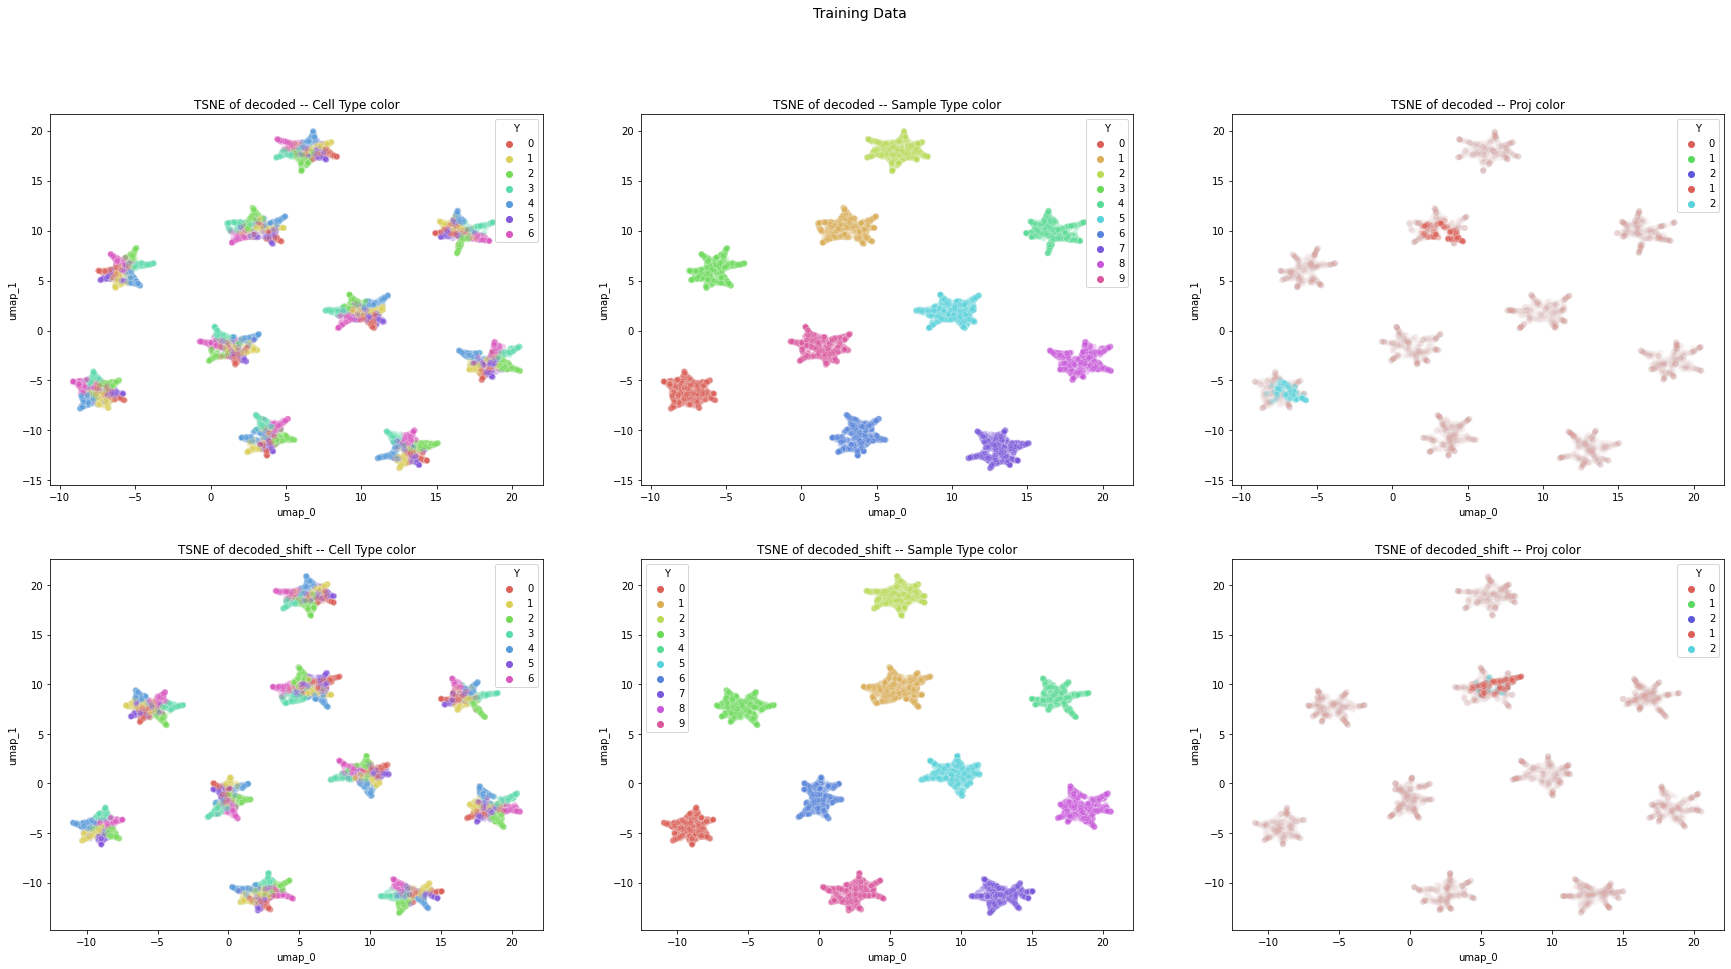

In [337]:

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)

idx_proj_cell0 = np.where(np.logical_and(Y_temp == 0, label_temp == 1))[0]
idx_reg_cell0 = np.where(np.logical_and(Y_temp == 0, label_temp == 0))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 samp 0"
proj_temp[idx_reg_cell0] = 2 #"cell0 samp 1"


only_cell_0_interest = np.union1d(idx_proj_cell0, idx_reg_cell0)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

plot_df = get_umap_for_plotting(np.asarray(decoded_0_0))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp, ax=axs[0,2], title="TSNE of decoded -- Proj color", alpha=0.01)
plot_umap(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[0,2], title="TSNE of decoded -- Proj color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp, ax=axs[1,2], title="TSNE of decoded_shift -- Proj color", alpha=0.01)
plot_umap(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color")


fig.suptitle("Training Data", fontsize=14)

fig.show()



(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


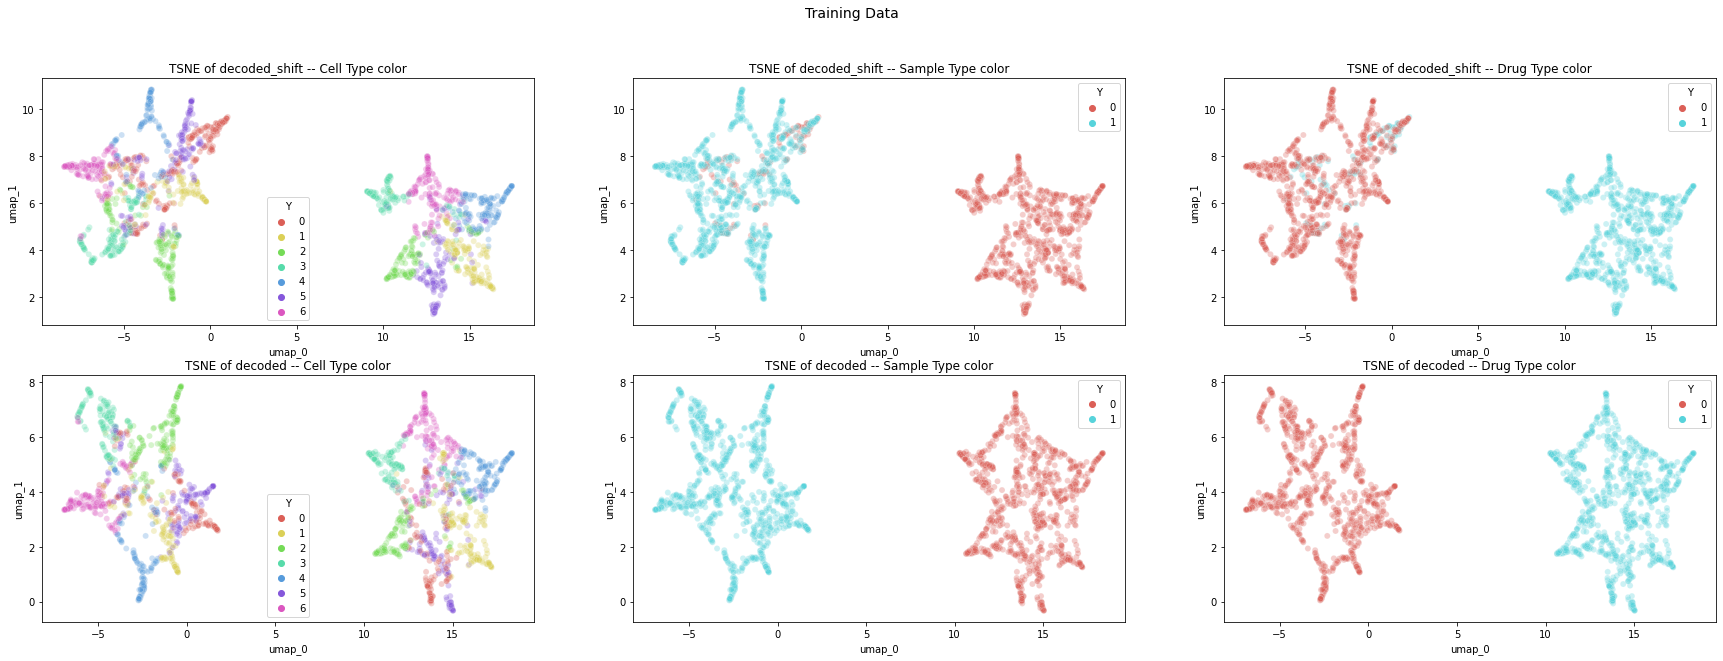

In [240]:

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

samp_0 = range(2000)

fig, axs = plt.subplots(2, 3, figsize=(30,10))

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[0,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp[samp_0], ax=axs[0,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp[samp_0], ax=axs[0,2], title="TSNE of decoded_shift -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_0[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[1,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp[samp_0], ax=axs[1,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp[samp_0], ax=axs[1,2], title="TSNE of decoded -- Drug Type color")


fig.suptitle("Training Data", fontsize=14)

fig.show()




(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


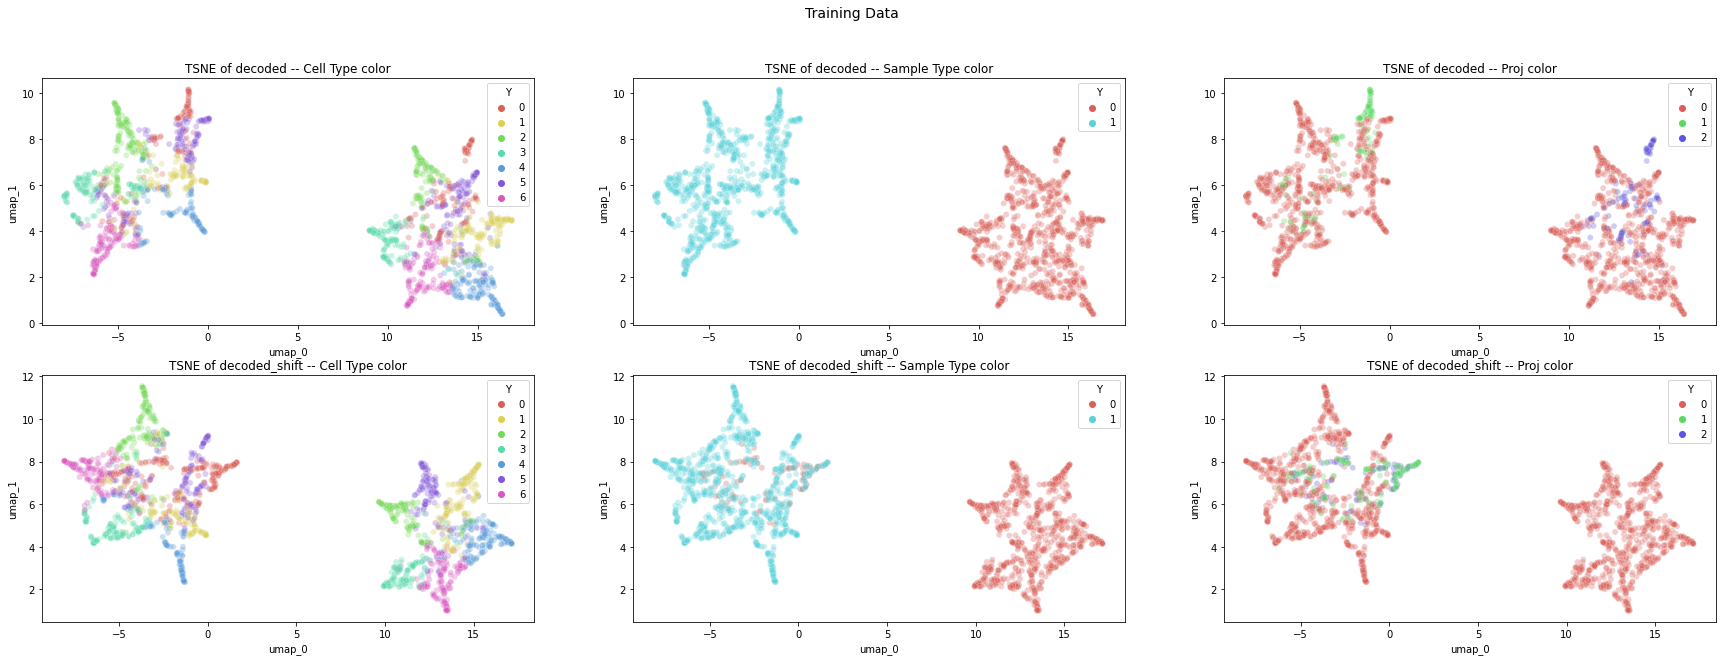

In [328]:

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)

idx_proj_cell0 = np.where(np.logical_and(Y_temp == 0, label_temp == 1))[0]
idx_reg_cell0 = np.where(np.logical_and(Y_temp == 0, label_temp == 0))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 projected to samp 1"
proj_temp[idx_reg_cell0] = 2 #"cell0 already in samp 1"


samp_0 = range(2000)

fig, axs = plt.subplots(2, 3, figsize=(30,10))


plot_df = get_umap_for_plotting(np.asarray(decoded_0_0[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[0,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp[samp_0], ax=axs[0,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp[samp_0], ax=axs[0,2], title="TSNE of decoded -- Proj color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp[samp_0], ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp[samp_0], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color")


fig.suptitle("Training Data", fontsize=14)

fig.show()



In [252]:
proj_temp[idx_proj_cell0]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])